In [1]:
import re
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zafarana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from __future__ import print_function
from time import time
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation and digits
    2. Remove all stopwords
    3. Stemms all words
    4. Returns a list of the cleaned text
    """
    #remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator)
    #print(text)
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text]  
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    #stem all words
    ps = PorterStemmer()
    nopunc = [token for token in nopunc.split(" ")]
    #remove duplicate words
    nopunc = unique_list(nopunc)
    # Join the characters again to form the string.
    nopunc = ' '.join(nopunc)  
    nopunc = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    nopunc = ' '.join(nopunc)    
    return nopunc 



In [6]:
# test text_process func
text = 'I me!! running\swimming/jumping running jumping swimming1 2 3 4'
text1 = text_process(text)
print(text1)

running swimming jumping


<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<input>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-6-4ba56f2ec810>:2: DeprecationWarning: invalid escape sequence \s
  text = 'I me!! running\swimming/jumping running jumping swimming1 2 3 4'


In [7]:
#df1=pd.read_csv('Feb2018SNOW.csv',encoding='iso-8859-1')

#df1.loc[:20000,:].to_csv('Feb2018SNOW_short.csv')

In [90]:
df1=pd.read_csv('Feb2018SNOW_short.csv',encoding='iso-8859-1')

In [8]:
applist = ['servicedesk-it4it', 'servicedesk-services es', 'servicedesk-services mslearning',
                                            'servicedesk-incentive comp', 'servicedesk-finance', 'servicedesk-dmp',
                                            'servicedesk-field it local language', 'servicedesk-field it emea', 
                                            'servicedesk-field it apgc', 'servicedesk-field it chinese', 'servicedesk-mbs',
                                            'servicedesk-ngvl', 'servicedesk-vl', 'servicedesk-vl order management',
                                            'servicedesk-css', 'servicedesk-partner membership', 'servicedesk-ax',
                                            'servicedesk-ax (chinese)', 'servicedesk-bi csms', 'servicedesk-bi platform',
                                            'servicedesk-dml', 'servicedesk-icoe', 'servicedesk-mdm ', 'servicedesk-sectools',
                                            'servicedesk-sap', 'servicedesk-sap bi', 'servicedesk-sap fico', 'servicedesk-sap hcm',
                                            'servicedesk-sap scm', 'servicedesk-sap technical', 'servicedesk-sap technical (inactive)',
                                            'servicedesk-hrit', 'servicedesk-lcait', 'servicedesk-bgit', 'servicedesk-partner incentives', 
                                            'servicedesk-product data master mgmt', 'servicedesk-release services', 'servicedesk-product key services',
                                            'servicedesk-core sales', 'servicedesk-app factory', 'servicedesk-tenant services',
                                            'servicedesk-product data master mgmt(uat)', 'servicedesk-product key services (uat)']
CIMlist=['service operations-windows','service operations-email & calendaring','service operations-skype',
                                           'service operations-sharepoint','service operations-power bi','service operations-msteams']

In [9]:
def mapufag(s):
    s=str(s).lower()
    if s in applist:
        return 'App'
    elif s.startswith('ghd'):
        return 'GHD'
    elif s.startswith('hst') or s.startswith('dst') or s.startswith('techlink'):
        return 'TL'
    elif s in CIMlist:
        return 'CIM'
    elif s.startswith('avlink-'):
        return 'AVLink'
    else:
        return 'Not Applicable'
    

In [10]:
df1['Tower_ufag'] = df1.loc[:,'u_first_assignment_group'].apply(mapufag)

df1['Tower_ag'] = df1.loc[:,'assignment_group'].apply(mapufag)

agg = df1[['u_first_assignment_group']].groupby(by='u_first_assignment_group') 

df1['Tower_ufag'].value_counts()

Not Applicable    81494
GHD               28318
App               25849
TL                17760
AVLink             3445
CIM                 413
Name: Tower_ufag, dtype: int64

In [11]:
 df1['Tower_ag'].value_counts()

Not Applicable    91444
App               20254
GHD               19726
TL                19197
AVLink             3813
CIM                2845
Name: Tower_ag, dtype: int64

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157279 entries, 0 to 157278
Data columns (total 19 columns):
number                      157279 non-null object
active                      157279 non-null bool
assigned_to                 152676 non-null object
assignment_group            157278 non-null object
u_first_assignment_group    157278 non-null object
short_description           157279 non-null object
description                 130728 non-null object
work_notes                  150706 non-null object
close_code                  152940 non-null object
close_notes                 152940 non-null object
reopen_count                157279 non-null int64
reassignment_count          157279 non-null int64
sys_created_on              157279 non-null object
resolved_at                 153405 non-null object
category                    154223 non-null object
subcategory                 143458 non-null object
cmdb_ci                     154318 non-null object
Tower_ufag                

In [13]:
df1['KB_articles'] = df1.work_notes.apply(lambda x: re.findall(r"(KB\d*)",str(x)))

In [14]:
df1['has_KB'] = df1.KB_articles.apply(lambda x: len(str(x))>3)

In [15]:
#df1[df1.has_KB].to_csv('kbarticles.csv')

In [16]:
MSFTData = df1[~df1.work_notes.isnull()]

In [18]:
MSFTData1 = MSFTData.iloc[:10000,:]

In [19]:
MSFTData1.reset_index(inplace=True)

In [20]:
MSFTData1['CleanComments1'] = MSFTData1['work_notes'].apply(lambda x:text_process(str(x)))

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
MSFTData1['CleanComments_cmdbi'] = MSFTData1['cmdb_ci'].apply(lambda x:text_process(str(x)))

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
MSFTData1[['CleanComments','CleanComments1','CleanComments_cmdbi']]

,CleanComments,CleanComments1,CleanComments_cmdbi
0,mark chou work note help instal window c rw e ...,mark chou work notes help install windows c rw...,windows rs fall creators update
1,martin junker work note outlook error start ad...,martin junker work notes outlook error start a...,microsoft office outlook rtm
2,yochanan rachamim work note incid creat suppor...,yochanan rachamim work notes incident created ...,office global
3,rachana adireddi work note complet request,rachana adireddy work notes completed request,msx dynamics crm online
4,rachana adireddi work note kill session,rachana adireddy work notes killed session,sales data hub
5,swarupa rani pithani work note issu msx buttom...,swarupa rani pithani work notes issue msx butt...,usd msx unified service desk
6,ranit da work note escal servicedesk finance s...,ranit das work notes escalated servicedesk fin...,microsoft reporting analytics msra
7,mark christoph sicat work note incid creat sup...,mark christopher sicat work notes incident cre...,nan
8,dirk willden work note need get clarif error s...,dirk willden work notes need get clarification...,saw
9,abhishek sarkar work note reach user user resp...,abhishek sarkar work notes reached user user r...,saw


In [22]:
MSFTData1.CleanComments1=MSFTData1.loc[:,'CleanComments1'].astype('str').apply(str.lower)
MSFTData1.CleanComments_cmdbi=MSFTData1.CleanComments_cmdbi.astype('str').apply(str.lower)

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [23]:
MSFTData1.loc[:,'combined']=MSFTData1.CleanComments_cmdbi+' '+ MSFTData1.CleanComments1

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
MSFTData1['CombinedTextList'] = MSFTData1['combined'].astype(str).str.split()

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
def GetITSMDict5(p):
    l =    ['password','reset','skype','login','kb','crash','crashed','outlook','network','chrome','troubleshoot',
            'smartcard','windows','unblock','error','ssd','email','T-Online','disable','corpnet','internet','intranet',
            'mssqlserver','office','setup','vpn','remote','reboot','smart','update','drivers','gpupdate','install',
            'language','rs','phone','registration','auth','auth','unable','unresponsive','cms','pin','disconnect','diconnected','corp','appwiz',
            'restart','recover','hang','freeze','problem','stopped','working','reopen','expired','domain','username','fail'
            'temporary','expired','disk','backup','unblock','pwd','virtual','physical','ews','escalation','new']
    ulist = []
    [ulist.append(x) for x in l if x in p]
    ulist = ' '.join(ulist)
    return ulist

MSFTData1['ITSMVocab'] =  MSFTData1['CombinedTextList'].apply(GetITSMDict5)


C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [28]:
MSFTData1['ITSMVocab'].astype(str)

0       skype kb windows error office update install r...
1                            outlook error office problem
2                                                  office
3                                                        
4                                                        
5                                           kb error corp
6            skype error email office install unable corp
7                                                        
8                            reset kb error smart virtual
9                             skype kb outlook email corp
10                                                  setup
11                                                       
12                                    error update unable
13                                                       
14                                         outlook office
15                                                       
16                                                       
17            

In [30]:
n_features = None
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(MSFTData1['ITSMVocab'].astype(str))
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.127s.


In [31]:
tfidf

<10000x61 sparse matrix of type '<class 'numpy.float64'>'
	with 42810 stored elements in Compressed Sparse Row format>

In [32]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20
# LDA
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 6.869s.


In [33]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [34]:
print("\nTopics in LDA model:")
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: email skype phone corp error kb working update outlook office windows unable corpnet network setup domain troubleshoot install login vpn
Topic #1: physical smartcard smart kb hang ssd troubleshoot phone email error unable network domain intranet install working corp drivers vpn stopped
Topic #2: reboot backup stopped corp email cms unresponsive unable skype ews remote windows office error disk phone problem language virtual username
Topic #3: working unable login error kb mssqlserver email update reboot password vpn corp domain phone corpnet reset restart setup ews skype
Topic #4: kb error corp domain setup unable email internet network windows troubleshoot working phone update install remote corpnet ssd problem outlook
Topic #5: password reset network error kb restart vpn unable remote virtual domain corp phone skype disconnect windows update email corpnet crashed
Topic #6: update skype phone error email problem corp kb working office outlook unable win

In [35]:
tf_feature_names

['appwiz',
 'auth',
 'backup',
 'chrome',
 'cms',
 'corp',
 'corpnet',
 'crash',
 'crashed',
 'disable',
 'disconnect',
 'disk',
 'domain',
 'drivers',
 'email',
 'error',
 'ews',
 'expired',
 'freeze',
 'gpupdate',
 'hang',
 'install',
 'internet',
 'intranet',
 'kb',
 'language',
 'login',
 'mssqlserver',
 'network',
 'office',
 'outlook',
 'password',
 'phone',
 'physical',
 'pin',
 'problem',
 'pwd',
 'reboot',
 'recover',
 'registration',
 'remote',
 'reopen',
 'reset',
 'restart',
 'rs',
 'setup',
 'skype',
 'smart',
 'smartcard',
 'ssd',
 'stopped',
 'troubleshoot',
 'unable',
 'unblock',
 'unresponsive',
 'update',
 'username',
 'virtual',
 'vpn',
 'windows',
 'working']

In [36]:
n_top_words

20

In [37]:
tfidf

<10000x61 sparse matrix of type '<class 'numpy.float64'>'
	with 42810 stored elements in Compressed Sparse Row format>

In [40]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)


In [41]:
pyLDAvis.show(panel)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [09/May/2018 14:30:54] "GET / HTTP/1.1" 200 -



stopping Server...


In [42]:
topics_pred = lda.transform(tfidf)

In [54]:
pd.DataFrame(topics_pred)

,0,1,2,3,4,5,6,7,8,9
0,0.025388,0.025394,0.025387,0.025390,0.025403,0.025391,0.025404,0.771450,0.025403,0.025391
1,0.033833,0.033834,0.033833,0.033835,0.033846,0.033835,0.335605,0.033838,0.393706,0.033835
2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050003,0.050002,0.549995,0.050001
3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
5,0.037131,0.037134,0.037143,0.037133,0.665784,0.037135,0.037139,0.037134,0.037132,0.037134
6,0.027756,0.027748,0.027742,0.027748,0.027745,0.027742,0.574414,0.203607,0.027757,0.027742
7,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
8,0.031714,0.269702,0.031714,0.031718,0.031734,0.476544,0.031718,0.031721,0.031715,0.031721
9,0.031318,0.031298,0.031300,0.031296,0.031308,0.031297,0.718259,0.031298,0.031327,0.031298


In [63]:
tp_df=pd.DataFrame(topics_pred,columns=["Topic_ "+str(i) for i in range(topics_pred.shape[1])])

In [72]:
MSFTData1['Topic'] = tp_df.idxmax(axis=1)

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
MSFTData1.columns

Index(['index', 'number', 'active', 'assigned_to', 'assignment_group',
       'u_first_assignment_group', 'short_description', 'description',
       'work_notes', 'close_code', 'close_notes', 'reopen_count',
       'reassignment_count', 'sys_created_on', 'resolved_at', 'category',
       'subcategory', 'cmdb_ci', 'Tower_ufag', 'Tower_ag', 'KB_articles',
       'has_KB', 'CleanComments1', 'CleanComments_cmdbi', 'combined',
       'CombinedTextList', 'ITSMVocab', 'topic', 'sys_created_dt',
       'resolved_dt', 'MTTR_approx', 'Topic'],
      dtype='object')

In [74]:
MSFTData1['sys_created_dt']=pd.to_datetime(MSFTData1.sys_created_on)

MSFTData1['resolved_dt']=pd.to_datetime(MSFTData1.resolved_at)

MSFTData1['MTTR_approx']=(MSFTData1['resolved_dt']-MSFTData1['sys_created_dt']).astype('timedelta64[s]')/86400

C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zafarana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is tryin

In [75]:
MSFT_final = MSFTData1.loc[:,['number', 'active', 'assigned_to', 'assignment_group',
'reopen_count','reopen_count', 'reassignment_count', 'sys_created_dt','resolved_dt', 'MTTR_approx', 'category',
       'subcategory','cmdb_ci', 'Tower_ufag', 'Tower_ag', 'KB_articles','ITSMVocab','Topic']]

In [76]:
MSFT_final

,number,active,assigned_to,assignment_group,reopen_count,reopen_count,reassignment_count,sys_created_dt,resolved_dt,MTTR_approx,category,subcategory,cmdb_ci,Tower_ufag,Tower_ag,KB_articles,ITSMVocab,Topic
0,INC17707796,False,Mark Chou,DST-Taiwan,0,0,0,2018-02-01 00:22:00,2018-02-01 01:06:00,0.030556,Application & Service,Installation,Windows 10 RS3 Fall Creators Update,TL,TL,[KB4040685],skype kb windows error office update install r...,Topic_ 7
1,INC17709210,False,Martin Junker,DST-Denmark,0,0,0,2018-02-01 02:50:00,2018-02-01 02:50:00,0.000000,Application & Service,Crash/Hang/Freeze,Microsoft Office Outlook 2016 (RTM),TL,TL,[],outlook error office problem,Topic_ 8
2,INC17708593,False,Priyanka Metai,GHD-WEB,0,0,0,2018-02-01 01:50:00,2018-02-01 04:34:00,0.113889,Application & Service,Login/Access,Office 365 Global,GHD,GHD,[],office,Topic_ 8
3,INC17710195,False,Rachana Adireddy,Service Operations-Core Sales,0,0,0,2018-02-01 04:47:00,2018-02-01 04:47:00,0.000000,Application & Service,Other,MSX Dynamics CRM Online,Not Applicable,Not Applicable,[],,Topic_ 0
4,INC17710274,False,Rachana Adireddy,Service Operations-Core Sales,0,0,0,2018-02-01 04:50:00,2018-02-01 04:50:00,0.000000,Application & Service,Other,Sales Data Hub,Not Applicable,Not Applicable,[],,Topic_ 0
5,INC17708611,False,Swarupa Rani Pithani,ServiceDesk-Core Sales,0,0,1,2018-02-01 01:52:00,2018-02-01 03:10:00,0.054167,Application & Service,Login/Access,USD-MSX Unified Service Desk,GHD,App,[KB],kb error corp,Topic_ 4
6,INC17708345,False,Udaykumar Reddy Gorla,ServiceDesk-Finance,0,0,1,2018-02-01 01:21:00,2018-02-01 06:11:00,0.201389,Application & Service,Login/Access,Microsoft Reporting Analytics (MSRA),GHD,App,[],skype error email office install unable corp,Topic_ 6
7,INC17712098,False,NaN,GHD-WEB,0,0,0,2018-02-01 08:04:00,2018-02-01 08:07:00,0.002083,Application & Service,NaN,NaN,GHD,GHD,[],,Topic_ 0
8,INC17708610,False,Dirk Willden,ServiceDesk-SAW,0,0,0,2018-02-01 01:52:00,2018-02-01 08:34:00,0.279167,Application & Service,Functionality,SAW,Not Applicable,Not Applicable,"[KB, KB0030733, KB0041932]",reset kb error smart virtual,Topic_ 5
9,INC17712047,False,Abhishek Sarkar,ServiceDesk-SAW,0,0,0,2018-02-01 07:59:00,2018-02-01 08:44:00,0.031250,Application & Service,Login/Access,SAW,Not Applicable,Not Applicable,"[KB0030733, KB0043639]",skype kb outlook email corp,Topic_ 6


In [87]:
MSFT_final.to_csv('MSFT_final.csv')

In [81]:
gr = MSFTData1.groupby(['Topic'])

In [82]:
gr.mean()

,index,active,reopen_count,reassignment_count,has_KB,MTTR_approx
Topic,,,,,,
Topic_ 0,6169.538753,0.005691,0.001084,0.134688,0.024390,0.176017
Topic_ 1,5048.763975,0.006211,0.006211,0.204969,0.736025,0.151661
Topic_ 2,5759.040404,0.000000,0.010101,0.737374,0.252525,0.367270
Topic_ 3,6131.362025,0.012658,0.005063,0.410127,0.286076,0.267683
Topic_ 4,6025.532847,0.015815,0.003650,0.434307,0.600973,0.247540
Topic_ 5,5433.830812,0.002751,0.004127,0.237964,0.433287,0.143289
Topic_ 6,5714.661333,0.023111,0.013333,0.562667,0.376889,0.395665
Topic_ 7,5585.554996,0.002876,0.009346,0.255931,0.727534,0.193473
Topic_ 8,5562.280220,0.038462,0.025641,0.545788,0.177656,0.301555


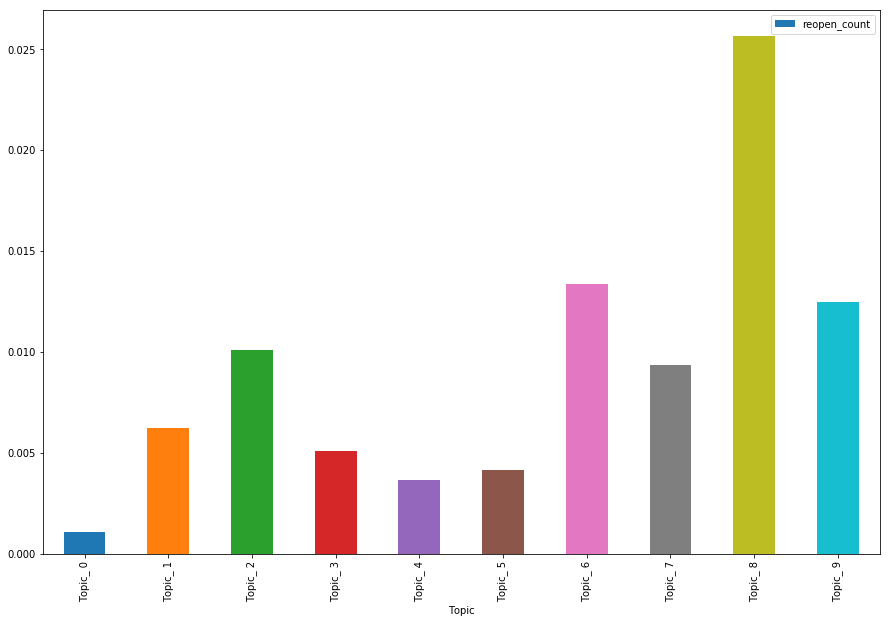

In [83]:
gr.mean().plot(y='reopen_count', kind='bar',figsize=[15,10])

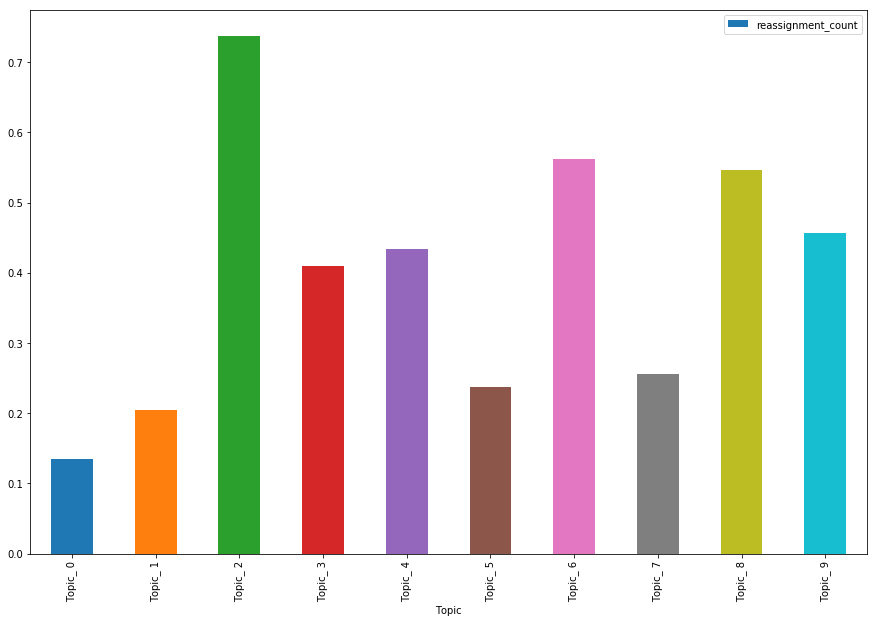

In [84]:
gr.mean().plot(y='reassignment_count', kind='bar',figsize=[15,10])

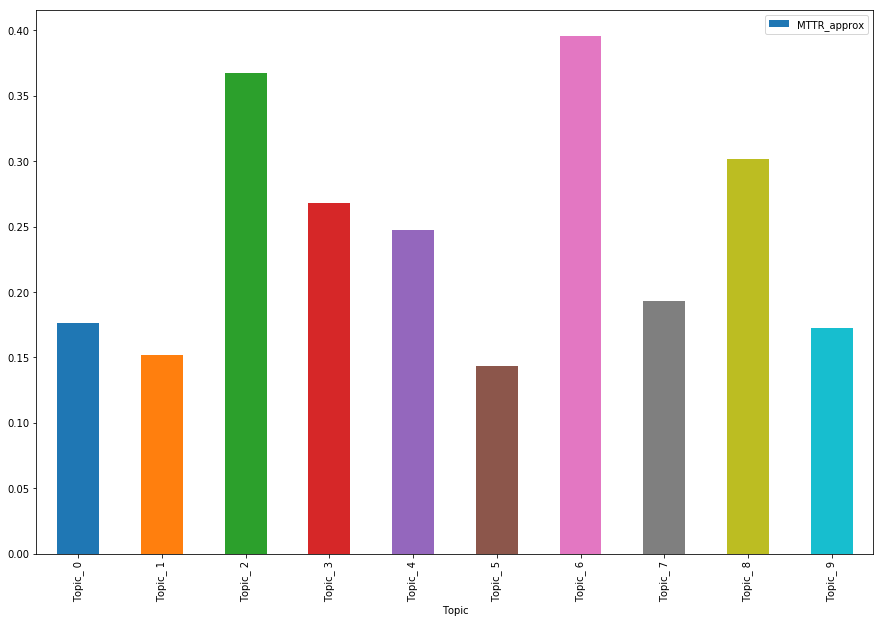

In [85]:
gr.mean().plot(y='MTTR_approx', kind='bar',figsize=[15,10])

In [86]:
MSFTData1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
index                       10000 non-null int64
number                      10000 non-null object
active                      10000 non-null bool
assigned_to                 9898 non-null object
assignment_group            10000 non-null object
u_first_assignment_group    10000 non-null object
short_description           10000 non-null object
description                 7882 non-null object
work_notes                  10000 non-null object
close_code                  9896 non-null object
close_notes                 9892 non-null object
reopen_count                10000 non-null int64
reassignment_count          10000 non-null int64
sys_created_on              10000 non-null object
resolved_at                 9896 non-null object
category                    9978 non-null object
subcategory                 9133 non-null object
cmdb_ci                     9956 non-null object
Tower